# **Analyzing WCA Competitors' Relative Performances in Big Cube Events**

Chanoe Andrew Park, Nate Ellis

Last updated: 5/15/2022

***

## **Introduction**

Solving a problem is one part. Optimizing a solution is another part.<br>

The invention of the Rubik's Cube dates back to 1974. The creator Ernő Rubik, a Hungarian architecture professor, reportedly spent about a month to solve the puzzle and return it to its original state for the first time since scrambling it. The puzzle was first available to the public in 1977 when the first batch of toys were released in Budapest. After its international debut in 1980, the very first Rubik's Cube competition was organized in Munich in 1981. These competitions signified the drive of competitors to improve  their solving times, and thus the rise of speedcubing. 

<p style="text-align:center;">
  <img src="./img/erno-rubik.jpg" alt="Ernő Rubik" width="350"/>
</p>

With rapid growth in the sport, the [World Cube Association](https://www.worldcubeassociation.org/) (WCA) was formed to hold and officiate twisty puzzle competitions. The traditional 3x3 Rubik's Cube isn't the only official event as there are a total of 17 different categories. In this project, we will be focusing on 4x4, 5x5, 6x6, and 7x7 events, which are frequently grouped as "big cube" events. 

<p style="text-align:center;">
<img src="./img/BigCubes.jpg" alt="4x4 through 7x7 cubes" width="350"/>
</p>

In many sports, there are different positions where the prioritized skillsets are different. For instance, in American football, the offensive lineman likely prioritizes size and blocking techniques over speed and agility. Strikers in soccer would focus more on their goal scoring abilities over defensive abilities. Within these prioritized skillsets, players could be equally good across the board or they could exceed in some categories but not in others. Using this inspiration and applying it to speedcubing in this project, we look to explore the correlations between big cube events, to perhaps find insight into how performance in one may relate to performance in another. 

***

## **Data Collection**

The WCA publicly maintains competition result data. Since there are competitions happening somewhere around the world every weekend, the dataset updates frequently. To get the most updated WCA dataset, we utilize the *requests* library and download the hosted ZIP file. 

In [1]:
import os
import requests
import shutil
import zipfile

data_dir = './WCA_data'
data_zip = f'{data_dir}.zip'

if os.path.isdir(data_dir):
    # Delete the existing data
    shutil.rmtree(data_dir)

if os.path.exists(data_zip):
    # Delete the zipped data
    os.remove(data_zip)

# Get data from WCA
url = 'https://www.worldcubeassociation.org/results/misc/WCA_export.tsv.zip'
r = requests.get(url, stream=True)

with open(data_zip, 'wb') as f:
    f.write(r.content)
            
# Extract zipped data
with zipfile.ZipFile(data_zip, 'r') as zf:
    zf.extractall(data_dir)

Once the file is extracted, various different datasets can be found. The one we will be using for this project is "WCA_export_RanksAverage.tsv". This dataset includes competitors' rankings in the world, continent, and country in the "average" category for a given event. In speedcubing, there are two different categories for all but one event: single and average. A single is the quickest time a competitor achieved in a round. An average is the mean solve time based on the number of solves in a round. For most events, such as 2x2 through 5x5, competitors attempt 5 solves. The quickest and slowest times are dropped before calculating the mean of the remaining 3 times, and this will be the "average of 5" for a competitor in a round. However, for some other events, such as 6x6 and 7x7, competitors only attempt 3 solves, and their average is computed as the mean of those 3 times without dropping any for a "mean of 3".

Let's go through a few exampls. First, let's say I'm competing in a round of 3x3 and got the following times (in seconds): **10.00, 9.26, 10.00, 10.00, 12.93**. My single time is 9.26 since it's my quickest time in this round. My average time is 10.00 because the mean is calculated after my fastest time (9.26) and slowest time (12.93) are dropped.

Next, let's say I'm competing in a round of 6x6 and got the following times (in seconds): **97.00, 93.00, 110.00**. My single time is 93.00, and my average time is 100.00 since none of the times will be dropped in 6x6.

To learn more about how to calculate averages in speedcubing, visit the [Speedsolving.com Wiki](https://www.speedsolving.com/wiki/index.php/Average)!

In [2]:
import numpy as np
import pandas as pd

df_avg = pd.read_csv(f'{data_dir}/WCA_export_RanksAverage.tsv', sep='\t', low_memory=False)
df_avg.head(5)

,personId,eventId,best,worldRank,continentRank,countryRank
0,2018KHAN28,222,102,1,1,1
1,2013EGDA02,222,121,2,1,1
2,2012CALL01,222,123,3,2,2
3,2016LIJI05,222,125,4,1,1
4,2012PATE01,222,127,5,2,1


Looking at the output above, the ranks average table columns seem to be formatted as below:
<br>
- personId: the unique identifier for a competitor
- eventId: specifies the event the following columns relate to
- best: the competitor's best average in one hundreth of a second
- {region}Rank: the competitor's rank based on {region}'s scope

With the current format of the ranks average table, each row only includes competitor data for a single event. This leads to the issue of missing data. Some competitors might not have competed in all big cube events, or possibly none of them at all. How are we supposed to compare how a competitor competes in 4x4 vs 7x7 if they have never competed in 7x7? The missing data is missing at random (MAR) because competitors generally work their way up in competing for larger NxN events, so competitors are more likely to be missing data for 6x6 and 7x7. Typically this poses a problem for datasets because imputation or replacing MAR data can often be inappropriate. Luckily, our specific premise requires that we have data for ALL relevant events, so in our case, we welcome dropping all of the missing data, as opposed to imputation.

To eliminate any missing data, we aggregate all big cube events data for a competitor into one row instead of having them separated row by row. Since this process is carried out by using inner joins, any competitor that does not have data for ALL big cube events will get dropped. The resulting dataframe will be complete with no missing data to worry about. A tradeoff for dropping data is that you could possibly lose useful information, however in our case this tradeoff is not a worry, because this information is useless to us unless it is complete, as we cannot make important comparisons. We have enough data for our analysis even if we drop the rows with missing data as well.

In [3]:
# Drop all events that we aren't interested in
df_avg.drop(df_avg[(df_avg.eventId < '444') | (df_avg.eventId > '777')].index, inplace=True)

# Only keep competitors with averages in all events we're interested in (4x4 through 7x7)
tmp = pd.merge(df_avg, df_avg, on='personId', suffixes=('_4', '_5'))
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId')
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | 
             (tmp.eventId != '666')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId', suffixes=('_6', '_7'))
df_grouped = tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | 
                          (tmp.eventId_6 != '666') | (tmp.eventId_7 != '777')].index)
df_grouped.reset_index(drop=True, inplace=True)

# Drop columns that won't be used going forward
cols = ['eventId', 'continentRank', 'countryRank']
df_grouped.drop([f'{col}_{n}' for col in cols for n in range(4, 8)], 
                axis = 1, inplace=True)

# Fix time scale
for n in range(4, 8):
    df_grouped[f'best_{n}'] = np.float64(df_grouped[f'best_{n}'] / 100.0)

df_grouped

,personId,best_4,worldRank_4,best_5,worldRank_5,best_6,worldRank_6,best_7,worldRank_7
0,2012PARK03,19.88,1,38.45,1,75.63,1,106.57,1
1,2010WEYE02,21.46,2,45.80,8,87.19,8,154.27,79
2,2009ZEMD01,21.57,3,42.09,3,81.90,5,120.63,4
3,2016KOLA02,22.00,4,39.79,2,80.36,3,122.46,5
4,2012PONC02,23.12,5,47.82,12,98.55,39,158.33,102
...,...,...,...,...,...,...,...,...,...
4240,2008VILL01,118.97,27206,182.45,13210,330.10,5725,557.57,4771
4241,2009KIVI01,123.89,27629,196.52,13578,340.73,5790,529.40,4727
4242,2011SANG02,139.73,28592,223.38,14052,541.09,6116,782.00,4842
4243,2008FERN03,146.66,28870,203.17,13733,511.27,6103,718.00,4831


***
## **Data Representation**

As we are relating four events, we have 4 dimensions of data. A data structure like a KD-Tree or quad-tree can sometimes be effective in visually representing data like this, but it is easiest and most intuitive to create 2-dimensional data and compare it this way. So, we need to take the two most similar events and group them. To do this, we create the violin plot below to see which two events are most similar. Not only are 4x4 & 5x5 and 6x6 & 7x7 similar in size, they also relate through similar mean, variance, and outliers. You can see that the variance for 4x4 & 5x5 is lower than that of 6x6 & 7x7 through the violin plot, and the outliers for 4x4 & 5x5 are significantly closer to the mean than 6x6 & 7x7. So, we will couple 4x4 & 5x5 into one group as A, and 6x6 & 7x7 into another group as B for future analysis and visualization.

Text(0.5, 1.0, 'Distribution by Event')

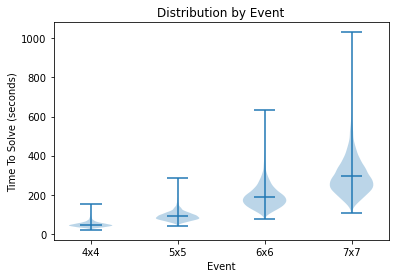

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12,7.5) # Create plot and size it
events = ['4x4', '5x5', '6x6', '7x7'] # Names for big cube events

# Create array with time data for each event
time_array = pd.DataFrame().assign(four = df_grouped['best_4'],
                                  five = df_grouped['best_5'],
                                  six = df_grouped['best_6'],
                                  seven = df_grouped['best_7'])

# Make and label violin plot
ax.violinplot(time_array,range(0,4,1),showmeans=True)
ax.set_xticks(np.arange(0,4,1), events)
ax.set_xlabel("Event")
ax.set_ylabel("Time To Solve (seconds)")
ax.set_title("Distribution by Event")


There also is the issue about solve times vs. rankings. How should we compare the data? The issue with solve times is that it takes much less time to solve 4x4 & 5x5 than it does to solve 6x6 & 7x7. We are trying to compare a competitor's performance between the two. Thus, we should standardize performance. If we used solve times to compare, we introduce a new variable into our data. Namely, performance for one event means something different than another. To standardize performance and thus reduce a variable in our data, we use world rankings instead, as a world ranking means the same from one event to another.

After we couple world rankings for the two groups, we create a scatterplot with the axes being the average world rank of the two groups, as well as the regression line. For our graph, 0 is at the top, and rank increases as you get closer to the origin. This is because intuitively it makes more sense for better ranked players to be near the top right. Thus with our plot structure, the higher ranked people in each event are closer to the top right of the plot, and the lower ranked people are closer to the bottom left.

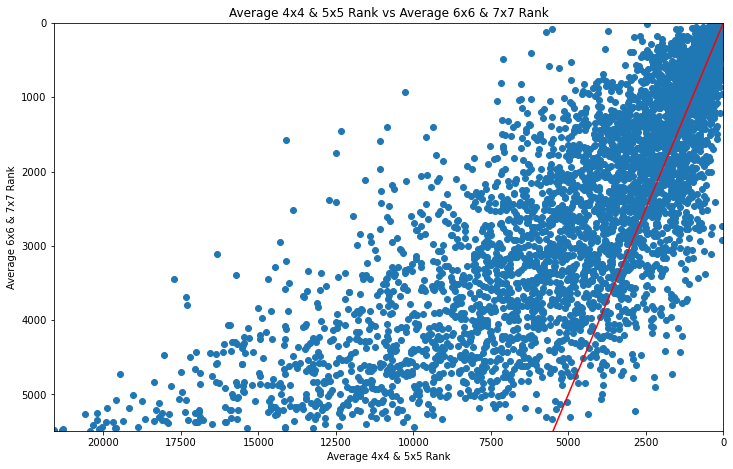

In [18]:
def create_scatter(df):
    # Randomized rows to look at sample if desired
    df_shuffled = df.sample(frac=1).reset_index(drop=True)

    # Create average 4x4 & 5x5 ranks and average 6x6 & 7x7 ranks
    combined_45 = (df_shuffled['worldRank_4'] + df_shuffled['worldRank_5']) / 2
    combined_67 = (df_shuffled['worldRank_6'] + df_shuffled['worldRank_7']) / 2

    plt.rcParams["figure.figsize"] = (12,7.5)

    # Plot Average 4x4 & 5x5 Rank vs Average 6x6 & 7x7 Rank
    sample_size = len(combined_45)  # Insert desired sample size to observe
    x = combined_45[:sample_size]
    y = combined_67[:sample_size]
    plt.scatter(x, y)
    plt.xlim(max(x), 0)
    plt.ylim(max(y), 0)
    plt.plot([max(x), 0], [max(x), 0], color='r') # plots line y = x
    plt.xlabel('Average 4x4 & 5x5 Rank')
    plt.ylabel('Average 6x6 & 7x7 Rank')
    plt.title('Average 4x4 & 5x5 Rank vs Average 6x6 & 7x7 Rank')

create_scatter(df_grouped)
plt.show()

It seems our plot is heavily skewed. As you can see, rankings get down to the 20,000's for group A, whereas they only get down to the 5000's for group B. This difference in range is due to the significant number of competitors that have competed in 4x4 & 5x5 but not both of 6x6 & 7x7. This skew makes it difficult to analyze the data.

At the start of this project, we limited our dataset to those who have competed in all big cube events. Thus, any competitor who hasn't competed in all big cube events are inflating the rank numbers, and it seems that group A has been affected more significantly. To remedy this, we recreate rankings based on the population in our dataset. So, what it means to be the bottom 10% is now limited and can be compared within our dataset. This is another variable that we can get rid of. Previously, what it meant to be ranked in one event compared to another meant different things, however, with this fix we erase this variable and standardize ranking.

Below we fix this issue by sorting the dataframe on an event and assigning its new rank derived from its index:

In [19]:
df_ranked = df_grouped.copy()

def contained_rank(n):
    # Reassign rankings for our dataset for NxN
    df_ranked.sort_values(by=f'worldRank_{n}', inplace=True)
    df_ranked.reset_index(drop=True, inplace=True)
    for i, row in df_ranked.iterrows():
        df_ranked.loc[i, f'worldRank_{n}'] = i + 1

for n in range(7, 3, -1):
    contained_rank(n)

df_ranked

,personId,best_4,worldRank_4,best_5,worldRank_5,best_6,worldRank_6,best_7,worldRank_7
0,2012PARK03,19.88,1,38.45,1,75.63,1,106.57,1
1,2010WEYE02,21.46,2,45.80,8,87.19,8,154.27,78
2,2009ZEMD01,21.57,3,42.09,3,81.90,5,120.63,4
3,2016KOLA02,22.00,4,39.79,2,80.36,3,122.46,5
4,2012PONC02,23.12,5,47.82,12,98.55,39,158.33,101
...,...,...,...,...,...,...,...,...,...
4240,2008VILL01,118.97,4241,182.45,4226,330.10,4151,557.57,4194
4241,2009KIVI01,123.89,4242,196.52,4230,340.73,4167,529.40,4165
4242,2011SANG02,139.73,4243,223.38,4239,541.09,4243,782.00,4239
4243,2008FERN03,146.66,4244,203.17,4233,511.27,4241,718.00,4230


***
## **Data Analysis**

We have now standardized competitor ranks to most effectively visualize our data. Now, we can look at the graph and extrapolate what it means. Below, we create a scatterplot with our newly standardized data. Then, we add a line of y=x.

Why is y=x important for this data? We are looking at rankings of group A to group B. Because we standardized what ranking meant, the units are the same. Both groups have the same number of competitors. Performance is relative here. So, if you are just as good at 4x4 & 5x5 relative to how good you are at 6x6 & 7x7, your rank is the same in each group. If you are a top 10% performer within our dataset in 4x4 & 5x5, and if you are a top 10% performer within our dataset in 6x6 & 7x7, your ranks for both should be similar if not equal. Therefore, the y=x line maps out expected equal performance between the two groups. If you are just as good relative to everyone else in both groups, you will lie on that y=x line. This works both ways, so the farther you are from that y=x line, the more "specialized" you are in one of the groups. Specifically, if you are to the left of the line you are more specialized in 6x6 & 7x7, and if you are to the right of the line you are more specialized in 4x4 & 5x5.

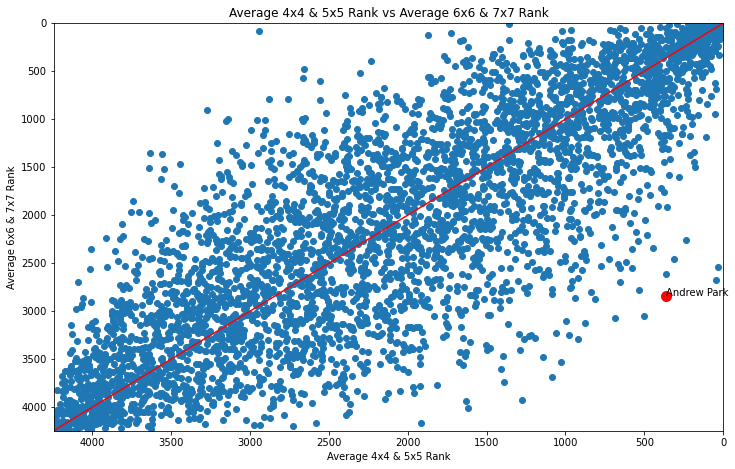

In [21]:
def mark_id(wca_id, name, color, size):
    # Marking competitor in the plot with a specified color and size
    df = df_ranked.loc[df_ranked['personId'] == wca_id]
    combined_45 = (df['worldRank_4'] + df['worldRank_5']) / 2
    combined_67 = (df['worldRank_6'] + df['worldRank_7']) / 2
    plt.plot(combined_45, combined_67, f'{color}o', ms=size)
    plt.text(combined_45, combined_67, name)

create_scatter(df_ranked)
mark_id('2013PARK03', 'Andrew Park', 'r', 10)
plt.show()

Each point represents a competitor. On the x-axis is their performance for 4x4 & 5x5, and on the y-axis is their performance for 6x6 & 7x7. As you can see, the distribution is fairly linear. However, the variance differs wildly, and people consolidate on the y=x line at both ends of the plot. This can be interpreted as people who are the best in one group are almost always also the best in the other group, and people who are the worst in one group are almost always the worst in the other group.

However, average-performing competitors see a more "specialization" effect observed by greater distance from the y=x line for points around the middle area of the plot. Though most still perform relatively the same between the two groups, some average competitors may perform poorly in one group but highly in another. In the plot, one point is colored red and larger than the others. This is Andrew Park, one of the authors of this project. As you can see, Andrew Park is a perfect example of this specialization effect. He is in the top 500 of 4x4 & 5x5 competitors, but only top 3000 of 6x6 & 7x7 performers. As stated earlier, this specialization effect is most prominent closer to the "middle of the pack". If you are great or poor in one group, that tends to be reflected in your ranking in the other.

***
## **Hypothesis Testing**

Which group's performances is best at predicting other events? Does group A (4x4 & 5x5) predict 6x6 and 7x7 rankings better or does group B (6x6 & 7x7) predict 4x4 and 5x5 rankings better? 

It is difficult to see which group would be better at predicting. We have already seen the distribution and it is fairly uniform. The hypothesis will be that group B would be better at predicting 4x4 and 5x5 because 6x6 & 7x7 averages are based on "mean of 3" where none of the times are dropped, so a competitor more likely demonstrates consistency. If a competitor is more consistent, then other event times may reflect it.

The prediction model will be a standard linear regression. Firstly, we cannot use something like LDA because these are rankings, not classifications. Thus, any classification function will not properly work. After testing various prediction models, namely SVM with different kernels and C values, ultimately standard linear regression was chosen for two reasons:

1. Dimensionality reduction. SVM has more input parameters than linear regression and thus may be more prone to overfitting.
2. The linear regression algorithm takes almost 0 runtime, whereas SVM took a few minutes

After testing both, SVM seemed to be slightly more accurate in terms of percent error. However, the percent error for linear regression was only different by about .2 or less and was also acceptable. Due to this minor difference, the benefits of dimensionality reduction and runtime seemed to outweigh the hit to percent error.

Another decision made was for the loss function. Mean absolute percent error was used because it effectively measures the loss in our data. Our data is numeric, thus not classifiable, so a binary loss function like a zero-one loss function would not work. Percent error is easy, intuitive, and common, so that's what was used. Other forms of loss functions didn't seem to fit or seemed unnecessary for our use case.

To research different loss functions or prediction models for yourself see:
- [Loss functions](https://analyticsindiamag.com/loss-functions-in-deep-learning-an-overview/)
- [Prediction models](https://towardsdatascience.com/selecting-the-correct-predictive-modeling-technique-ba459c370d59)

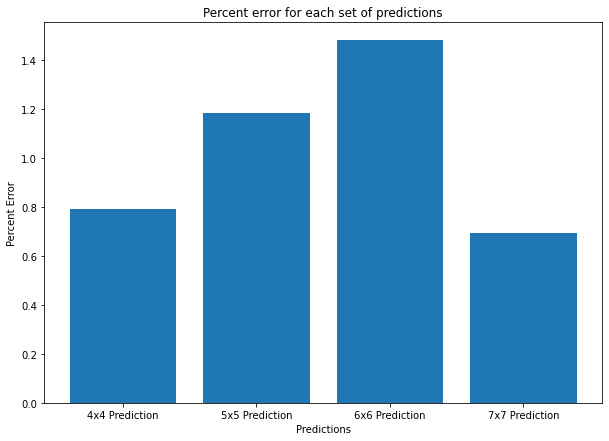

In [8]:
from sklearn.model_selection import train_test_split  
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


df_shuffled = df_ranked.sample(frac=1).reset_index(drop=True)
# Couple our data into 2 groups for prediction scheme
# Create group A using 4x4 & 5x5 ranks
groupA_X = pd.DataFrame().assign(four=df_shuffled['worldRank_4'], five=df_shuffled['worldRank_5'])
# Create group B using 6x6 & 7x7 ranks
groupB_X = pd.DataFrame().assign(six=df_shuffled['worldRank_6'], seven=df_shuffled['worldRank_7'])

prediction_percent_error = []  # Array used to visualize percent error for each prediction

for rank in ['worldRank_6', 'worldRank_7']: # Use group A to predict through linear regression 6x6 & 7x7 results
    X_train, X_test, y_train, y_test = train_test_split(groupA_X, df_shuffled[rank], test_size=0.4, random_state=0)
    reg = LinearRegression().fit(X_train, y_train)
    prediction_percent_error.append(mean_absolute_percentage_error(y_test, reg.predict(X_test)))
    
for rank in ['worldRank_4', 'worldRank_5']: # Use group B to predict through linear regression 4x4 & 5x5 results
    X_train, X_test, y_train, y_test = train_test_split(groupB_X, df_shuffled[rank], test_size=0.4, random_state=0)
    reg = LinearRegression().fit(X_train, y_train)
    prediction_percent_error.append(mean_absolute_percentage_error(y_test, reg.predict(X_test)))

names = ['4x4 Prediction', '5x5 Prediction', '6x6 Prediction', '7x7 Prediction'] # Names for plot
                      
#Create plot and adjust size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(names, prediction_percent_error)
plt.xlabel('Predictions')
plt.ylabel('Percent Error')
plt.title('Percent error for each set of predictions')
 
# Show Plot
plt.show()

It seems the hypothesis was wrong. Because the WCA data changes frequently, it is likely that this graph above may change from the time of writing. However, it is clear that 5x5 and 6x6 have a higher percent error than 4x4 and 7x7. Still, all four are within an acceptable range. 4x4 and 7x7 are similar in percent error whereas the two middle events are slightly higher. A reasoning for why this occurs is a form of "black sheep" effect. 4x4 is the next step up from 3x3 and is often the first puzzle learned after 3x3. The competitors are high in this event thus it is slightly normalized. Then 7x7 is the largest official NxN cube to solve, and many might like to specialize in this event. The other two are just in an awkward limbo of not being special for any particular reason. This potentially explains why 5x5 and 6x6 have a higher percent error, which is due to a lower competitor base.

***
## **Conclusion**

Overall, the two key insights we gained from the visualization, prediction, and analysis are that average performers tend to specialize more in one group of events or the other. High performers tend to perform greatly at both events, and low performers tend to perform poorly at poor events, but in the middle people often veer off to one group or the other. Also, it is difficult to predict rankings of 5x5 and 6x6 because they are in an awkward position of few people specializing in them competitively. 7x7 is the largest official NxN cube, and 4x4 is the next step to 3x3, so they see more regular rankings, as opposed to the two awkward middle children.